# Double DK rumour spreading model


In [149]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

class State(Enum):
    IGNORANT = 0 # People who haven't encountered the rumour
    RUMOUR_SPREADER = 1 # People actively spreading the rumour
    RUMOUR_CONTAINER = 2 # People who have heard the rumour but are not spreading it
    TRUTH_SPREADER = 3 # People actively spreading the truth
    TRUTH_CONTAINER = 4 # People who have heard the truth but are not spreading it

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLIQUISHNESS = 44

ACTIVENESS = 0.05
RUMOUR_ACCEPTANCE_PROB = 0.4
TRUTH_ACCEPTANCE_PROB = 0.7

SPREADER_SPREADER_STIFLE_PROB = 0.2
SPREADER_STIFLER_STIFLE_PROB = 0.1

FORGET_PROB = 0.01

In [150]:
class DKModel:
    def __init__(self, graph, initial_rumour_spreaders: int, initial_truth_spreaders: int) -> None:
        self.graph = graph

        # Initialize states
        self.states = {node: State.IGNORANT for node in graph.nodes}
        rumour_starters = np.random.choice(graph.nodes, initial_rumour_spreaders, replace=False)
        for node in rumour_starters:
            self.states[node] = State.RUMOUR_SPREADER
        truth_starters = np.random.choice(graph.nodes, initial_truth_spreaders, replace=False) # TODO: make sure not the same as the rumour starters
        for node in truth_starters:
            self.states[node] = State.TRUTH_SPREADER

        # History tracking
        self.i_history = []
        self.rs_history = []
        self.rc_history = []
        self.ts_history = []
        self.tc_history = []

    def step(self) -> None:
        new_states = self.states.copy()

        for node in self.graph.nodes:
            if self.states[node] == State.RUMOUR_SPREADER:
                neighbors = list(self.graph.neighbors(node))

                for neighbor in neighbors:
                    if np.random.random() > ACTIVENESS:
                        continue

                    # If neighbour is ignorant
                    if self.states[neighbor] == State.IGNORANT:
                        if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                            new_states[neighbor] = State.RUMOUR_SPREADER
                        elif np.random.random() < 1 - RUMOUR_ACCEPTANCE_PROB:
                            new_states[neighbor] = State.RUMOUR_CONTAINER
                    # If neighbour is a spreader
                    elif self.states[neighbor] == State.RUMOUR_SPREADER:
                        if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                            new_states[neighbor] = State.RUMOUR_CONTAINER
                        if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                            new_states[node] = State.RUMOUR_CONTAINER
                    # If neighbour is a stifler
                    elif self.states[neighbor] == State.RUMOUR_CONTAINER:
                        if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                            new_states[node] = State.RUMOUR_CONTAINER
                    # If neighbour knows the truth
                    elif self.states[neighbor] == State.TRUTH_SPREADER or self.states[neighbor] == State.TRUTH_CONTAINER:
                        if np.random.random() < TRUTH_ACCEPTANCE_PROB:
                            new_states[node] = State.TRUTH_SPREADER

            if self.states[node] == State.TRUTH_SPREADER:
                neighbors = list(self.graph.neighbors(node))

                for neighbor in neighbors:
                    if np.random.random() > ACTIVENESS:
                        continue

                    # If neighbour is ignorant
                    if self.states[neighbor] == State.IGNORANT:
                        if np.random.random() < TRUTH_ACCEPTANCE_PROB:
                            new_states[neighbor] = State.TRUTH_SPREADER
                        elif np.random.random() < 1 - TRUTH_ACCEPTANCE_PROB:
                            new_states[neighbor] = State.TRUTH_CONTAINER
                    # If neighbour is a spreader
                    elif self.states[neighbor] == State.TRUTH_SPREADER:
                        if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                            new_states[neighbor] = State.TRUTH_CONTAINER
                        if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                            new_states[node] = State.TRUTH_CONTAINER
                    # If neighbour is a stifler
                    elif self.states[neighbor] == State.TRUTH_CONTAINER:
                        if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                            new_states[node] = State.TRUTH_CONTAINER
                    # If neighbour knows the rumour
                    elif self.states[neighbor] == State.RUMOUR_SPREADER or self.states[neighbor] == State.RUMOUR_CONTAINER:
                        if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                            new_states[node] = State.RUMOUR_SPREADER

            # Random chance to become an ignorant again
            if np.random.random() < FORGET_PROB:
                new_states[node] = State.IGNORANT
                continue

        self.states = new_states

        # Count states
        ignorants = list(self.states.values()).count(State.IGNORANT)
        rumour_spreaders = list(self.states.values()).count(State.RUMOUR_SPREADER)
        rumour_containers = list(self.states.values()).count(State.RUMOUR_CONTAINER)
        truth_spreaders = list(self.states.values()).count(State.TRUTH_SPREADER)
        truth_containers = list(self.states.values()).count(State.TRUTH_CONTAINER)

        self.i_history.append(ignorants)
        self.rs_history.append(rumour_spreaders)
        self.rc_history.append(rumour_containers)
        self.ts_history.append(truth_spreaders)
        self.tc_history.append(truth_containers)

    def draw(self) -> None:
        plt.figure(figsize=(10, 6))

        # Assemble colour map
        colours = []
        for node in self.graph.nodes:
            if self.states[node] == State.IGNORANT:
                colours.append('red')
            elif self.states[node] == State.RUMOUR_SPREADER:
                colours.append('blue')
            elif self.states[node] == State.RUMOUR_CONTAINER:
                colours.append('green')
            elif self.states[node] == State.TRUTH_SPREADER:
                colours.append('purple')
            elif self.states[node] == State.TRUTH_CONTAINER:
                colours.append('yellow')

        nx.draw(self.graph, node_size=50, node_color=colours, with_labels=False)
        plt.title('DK Model of Rumor Propagation on a Graph')
        plt.show()

    def run(self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
        if draw:
            self.draw()

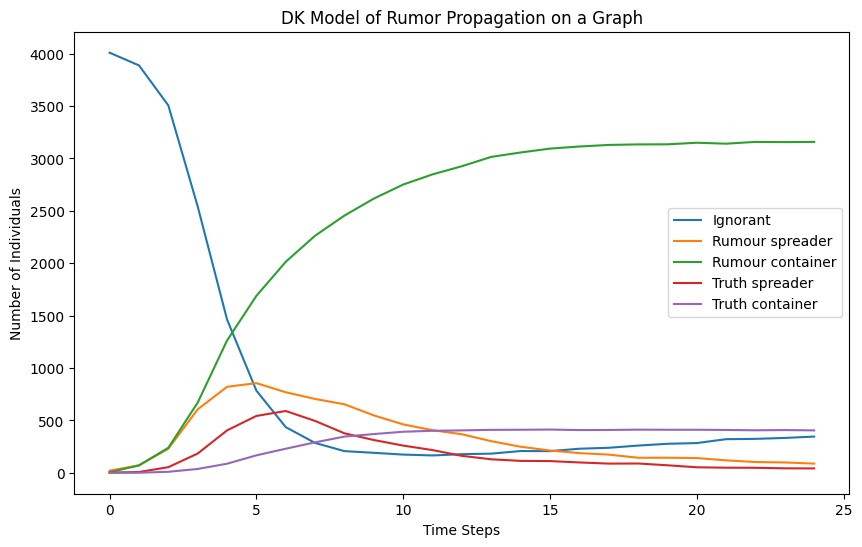

In [151]:
graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
dk_model = DKModel(graph, initial_rumour_spreaders=5, initial_truth_spreaders=1)
dk_model.run(TIME_STEPS, draw=False)

plt.figure(figsize=(10, 6))
plt.plot(dk_model.i_history, label='Ignorant')
plt.plot(dk_model.rs_history, label='Rumour spreader')
plt.plot(dk_model.rc_history, label='Rumour container')
plt.plot(dk_model.ts_history, label='Truth spreader')
plt.plot(dk_model.tc_history, label='Truth container')
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

